In [1]:

###############################################################################################################################
###############################################################################################################################

# IMPORTS

###############################################################################################################################
###############################################################################################################################


In [2]:
# IMPORTS AHMED

import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

from pyspark.sql.functions import col, when, to_timestamp, unix_timestamp, udf
from pyspark.sql.types import DoubleType

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
# IMPORTS

from pyspark.sql.types import (StructField,StructType, BooleanType, DoubleType,LongType)
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType, ArrayType, StringType, FloatType, DataType, TimestampType, Row
import inspect
from pyspark.sql.functions import lit
from pyspark.sql.functions import explode

from pyspark.sql import DataFrame
from pyspark.rdd import RDD
import math

import numpy as np
from matplotlib import pyplot as plt 


In [4]:

###############################################################################################################################
###############################################################################################################################

# LECTURE DE L'ENSEMBLE DE DONNéES

###############################################################################################################################
###############################################################################################################################


In [5]:

# LECTURE DU FICHIER EN ENTREE
rdd_data = spark.read.option("header",True).option("inferSchema",True).csv("VGP-week3-data.csv")


In [6]:

# AFFICHER LE SCHEMA DU FICHIER
rdd_data.printSchema()

# AFFICHER LE PREMIER TUPLE
rdd_data.first()


root
 |-- kit_id: integer (nullable = true)
 |-- participant_id: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- PM2-5: string (nullable = true)
 |-- PM10: string (nullable = true)
 |-- PM1-0: string (nullable = true)
 |-- NO2: string (nullable = true)
 |-- BC: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- event: string (nullable = true)



Row(kit_id=80, participant_id=9999964, time='2019-11-14 09:00:00', lat=48.7717766666667, lon=2.006005, PM2-5='NULL', PM10='NULL', PM1-0='NULL', NO2='NULL', BC='NULL', activity='NULL', event='NULL')

In [7]:

# RENOMMER LES COLONNES EN CHANGEANT "-" PAR "_"
rdd_data = rdd_data.withColumnRenamed('PM2-5','PM2_5')
rdd_data = rdd_data.withColumnRenamed('PM1-0','PM1_0')


#On change les string "NULL" en null
rdd_data = rdd_data.withColumn(("BC"), when(col("BC") == "NULL", None).otherwise(col("BC")))
rdd_data = rdd_data.withColumn(("PM2_5"), when(col("PM2_5") == "NULL", None).otherwise(col("PM2_5")))
rdd_data = rdd_data.withColumn(("PM10"),  when(col("PM10") == "NULL",  None).otherwise(col("PM10")))
rdd_data = rdd_data.withColumn(("PM1_0"), when(col("PM1_0") == "NULL", None).otherwise(col("PM1_0")))
rdd_data = rdd_data.withColumn(("NO2"),   when(col("NO2") == "NULL",   None).otherwise(col("NO2")))
rdd_data = rdd_data.withColumn(("activity"), when(col("activity") == "NULL", None).otherwise(col("activity")))
rdd_data = rdd_data.withColumn(("event"), when(col("event") == "NULL", None).otherwise(col("event")))

# VERIFICATION DU CHANGEMANT
rdd_data.first()


Row(kit_id=80, participant_id=9999964, time='2019-11-14 09:00:00', lat=48.7717766666667, lon=2.006005, PM2_5=None, PM10=None, PM1_0=None, NO2=None, BC=None, activity=None, event=None)

In [8]:

# AFFECTAION DE LA DF "rdd_data" à "df_data" (POUR NE PAS CHANGER LE CODE APRES NOUS ALLONS L'ENLEVER)
df_data = rdd_data

df_data.printSchema()

df_data.show(5)


root
 |-- kit_id: integer (nullable = true)
 |-- participant_id: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- PM2_5: string (nullable = true)
 |-- PM10: string (nullable = true)
 |-- PM1_0: string (nullable = true)
 |-- NO2: string (nullable = true)
 |-- BC: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- event: string (nullable = true)

+------+--------------+-------------------+----------------+--------+-----+----+-----+----+----+--------+-----+
|kit_id|participant_id|               time|             lat|     lon|PM2_5|PM10|PM1_0| NO2|  BC|activity|event|
+------+--------------+-------------------+----------------+--------+-----+----+-----+----+----+--------+-----+
|    80|       9999964|2019-11-14 09:00:00|48.7717766666667|2.006005| null|null| null|null|null|    null| null|
|    80|       9999964|2019-11-14 09:00:10|48.7717766666667|2.006005| null|null| null|null|null|  

In [9]:

# CONVERSION DE LA DATE EN TIMESTAMP (DE TYPE "LONG")

df_data = df_data.withColumn('time', unix_timestamp('time','yyyy-MM-dd HH:mm:ss').alias('time'))


In [10]:

# VERIFICATION DE LA BONNE CONVERSION DE LA DATE

df_data.where(col('time').isNotNull()).show()
df_data.printSchema()


+------+--------------+----------+----------------+----------------+-----+----+-----+----+----+--------+-----+
|kit_id|participant_id|      time|             lat|             lon|PM2_5|PM10|PM1_0| NO2|  BC|activity|event|
+------+--------------+----------+----------------+----------------+-----+----+-----+----+----+--------+-----+
|    80|       9999964|1573718400|48.7717766666667|        2.006005| null|null| null|null|null|    null| null|
|    80|       9999964|1573718410|48.7717766666667|        2.006005| null|null| null|null|null|    null| null|
|    80|       9999964|1573718420|48.7717766666667|        2.006005| null|null| null|null|null|    null| null|
|    80|       9999964|1573718430|48.7717766666667|        2.006005| null|null| null|null|null|    null| null|
|    80|       9999964|1573718440|48.7717766666667|        2.006005| null|null| null|null|null|    null| null|
|    80|       9999964|1573718450|48.7717766666667|        2.006005| null|null| null|null|null|    null| null|
|

In [11]:

###############################################################################################################################
###############################################################################################################################

# DEFINITION DES ADTs

###############################################################################################################################
###############################################################################################################################


In [12]:

#######################################################

# ADTs TEMPORELS

#######################################################


In [13]:

# TYPE INTIME (val, t)

IntimeSchema = [StructField('val', FloatType(),True),
                 StructField('t', LongType(),True)]
IntimeType = StructType(fields=IntimeSchema)


In [14]:
# TYPE UREAL (a, b, c, r, t1, t2)

URealSchema = [StructField('a', IntegerType(),True),
              StructField('b', DoubleType(),True),
              StructField('c', DoubleType(),True),
              StructField('r', BooleanType(),True),
              StructField('t1', LongType(),True),
              StructField('t2', LongType(),True)]
URealType = StructType(URealSchema)


In [15]:

# TYPE MREAL (Array(UREAL))

MRealSchema = [StructField('time_units', ArrayType(URealType),True)]
MRealType = StructType(MRealSchema)


In [16]:

#######################################################

# ADTs SPATIALES

#######################################################


In [17]:

# TYPE SPOINT

SPointSchema = [StructField('lat', DoubleType(),True),
                StructField('lon', DoubleType(),True)]
SPointType = StructType(fields=SPointSchema)


In [18]:

# TYPE SECTION

SectionSchema = [StructField('p1', SPointType,True),
                 StructField('p2', SPointType,True)]
SectionType = StructType(fields=SectionSchema)


In [19]:

# TYPE LINE

LineSchema = [StructField('sections', ArrayType(SectionType),True)]
LineType = StructType(fields=LineSchema)


In [20]:

# TYPE USPOINT

USPointSchema = [StructField('t1', LongType(),True),
                 StructField('t2', LongType(),True),
                 StructField('p1', SPointType,True),
                 StructField('p2', SPointType,True)]
USPointType = StructType(fields=USPointSchema)


In [21]:

# TYPE MSPoint

MSPointSchema = [StructField('uspoints', ArrayType(USPointType),True)]
MSPointType   = StructType(fields=MSPointSchema)


In [22]:

# TYPE InSPoint

InSPointSchema = [StructField('val', DoubleType(),True),
                 StructField('uspoints', SPointType,True)]
InSPointType   = StructType(fields=InSPointSchema)


In [23]:

# TYPE USREAL (a, b, c, r, p1, p2)

USRealSchema = [StructField('a', DoubleType(),True),
              StructField('b', DoubleType(),True),
              StructField('c', DoubleType(),True),
              StructField('r', BooleanType(),True),
              StructField('p1', SPointType,True),
              StructField('p2', SPointType,True)]
USRealType = StructType(USRealSchema)


In [24]:

# TYPE MSREAL (Array(USREAL))

MSRealSchema = [StructField('space_units', ArrayType(USRealType),True)]
MSRealType = StructType(MSRealSchema)


In [25]:

################################################################################################################################
################################################################################################################################

# CREATION DES PROFILES 

################################################################################################################################
################################################################################################################################


In [26]:
# PROCESSUS DE CREATION DES PROFILES

#######################################################
#######################################################

In [27]:

# NETOYAGE DE L'ENSEMBLE DE DONNEES
DataSet = df_data.filter(df_data["time"].isNotNull() & df_data["lat"].isNotNull() & df_data["lon"].isNotNull() & df_data["PM2_5"].isNotNull() & df_data["PM10"].isNotNull() & df_data["PM1_0"].isNotNull() & df_data["NO2"].isNotNull() & df_data["BC"].isNotNull() & df_data["activity"].isNotNull() & df_data["event"].isNotNull() ).select("participant_id","time", "lat", "lon", "PM2_5", "PM10","PM1_0","NO2","BC","activity","event")

# AFFICHAGE DE L'ENSEMBLE APRES NETOYAGE
DataSet.show(5)


+--------------+----------+----------------+----------------+-----+----+-----+---+---+--------+-------------------+
|participant_id|      time|             lat|             lon|PM2_5|PM10|PM1_0|NO2| BC|activity|              event|
+--------------+----------+----------------+----------------+-----+----+-----+---+---+--------+-------------------+
|       9999964|1573804980|48.7717266666667|2.00586333333333|    3|   4|    4|  7|376|  Bureau|Arrêter De Cuisiner|
|       9999964|1573804990|48.7717266666667|2.00586333333333|    3|   4|    4|  7|376|  Bureau|Arrêter De Cuisiner|
|       9999964|1573805000|48.7717266666667|2.00586333333333|    3|   4|    4|  7|376|  Bureau|Arrêter De Cuisiner|
|       9999964|1573805010|48.7717266666667|2.00586333333333|    3|   4|    4|  7|376|  Bureau|Arrêter De Cuisiner|
|       9999964|1573805020|48.7717266666667|2.00586333333333|    3|   4|    4|  7|376|  Bureau|Arrêter De Cuisiner|
+--------------+----------+----------------+----------------+-----+----+

In [28]:

# CALCUL DES CLES DE CHAQUE PAIRE (LATITUDE, LONGITUDE)

# FONCTION DE CALCUL DES CLES
#def extraction_cle(latitude_row, longitude_row):
#    key = math.sqrt((longitude_row*longitude_row) + (latitude_row*latitude_row))
#    return key

def extraction_cle(long, lat):
    precision_long = 4
    ent=int(long*pow(10,precision_long))*10
    if long < 0:
        ent=-ent+1
    dec=lat/pow(10,3)
    if dec < 0:
        dec= -dec 
        dec+=pow(10,-1)
    return ent+dec

def extraction_pos_from_cle(key):
    precision_long = 4
    ent = int(key)
    if ent % 10 == 1:
        ent = -ent 
    ent = int(ent/10)
    long = ent / pow(10,precision_long)
    dec = key - int(key) 
    if int(dec*10)==1:
        dec = -dec 
    dec = dec*10 - int(dec*10)
    lat = dec * pow(10,2)
    return long,lat 

# DEFINITION DE L'UDF
udfKey = udf(extraction_cle, DoubleType())

# CALCUL DES CLES
DataSet = DataSet.withColumn('keys', udfKey('lat','lon'))



In [29]:
DataSet.select("lat","lon","keys").show()

+----------------+----------------+-----------------+
|             lat|             lon|             keys|
+----------------+----------------+-----------------+
|48.7717266666667|2.00586333333333|4877170.002005863|
|48.7717266666667|2.00586333333333|4877170.002005863|
|48.7717266666667|2.00586333333333|4877170.002005863|
|48.7717266666667|2.00586333333333|4877170.002005863|
|48.7717266666667|2.00586333333333|4877170.002005863|
|48.7717266666667|2.00586333333333|4877170.002005863|
|48.7717316666667|         2.00585| 4877170.00200585|
|48.7717316666667|         2.00585| 4877170.00200585|
|48.7716833333333|2.00596833333333|4877160.002005968|
|48.7716833333333|2.00596833333333|4877160.002005968|
|48.7717216666667|2.00613833333333|4877170.002006139|
|48.7717216666667|2.00613833333333|4877170.002006139|
|       48.771845|2.00604333333333|4877180.002006044|
|        48.77189|2.00580666666667|4877180.002005807|
|        48.77189|2.00580666666667|4877180.002005807|
|        48.77189|2.00580666

In [30]:

# AGGREGATION DES DONNEES GROUPéS PAR PARTICIPANT
DataSet = DataSet.groupBy("participant_id").agg(F.collect_list(col('time')).alias('time'),F.collect_list(col('lat')).alias('lat'),F.collect_list(col('keys')).alias('keys'),F.collect_list(col('lon')).alias('lon'),F.collect_list(col('PM2_5')).alias('PM2_5'),F.collect_list(col('PM10')).alias('PM10'),F.collect_list(col('PM1_0')).alias('PM1_0'),F.collect_list(col('NO2')).alias('NO2'),F.collect_list(col('BC')).alias('BC'),F.collect_list(col('activity')).alias('activity'),F.collect_list(col('event')).alias('event'))

# AFFICHAGE DES DONNES APRES AGGREGATION
DataSet.select("participant_id", "time", "lat", "lon", "keys", "PM2_5", "activity").show(5)



+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|participant_id|                time|                 lat|                 lon|                keys|               PM2_5|            activity|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       9999960|[1574064040, 1574...|[48.8582383333333...|[2.34773166666667...|[4885820.00234773...|[9, 7, 7, 9, 9, 8...|[Bureau, Bureau, ...|
|       9999964|[1573804980, 1573...|[48.7717266666667...|[2.00586333333333...|[4877170.00200586...|[3, 3, 3, 3, 3, 3...|[Bureau, Bureau, ...|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [31]:
DataSet.select("keys").head()[0][0]

4885820.002347732

In [32]:

###############################################################################################################################
###############################################################################################################################

# Fonctions POUR LA CRéATION DES PROFILES

###############################################################################################################################
###############################################################################################################################


In [33]:

# DEFINITION DE LA METHODE DE LA CREATION DU TRIP (MSPOINT)

def trip_creation(time_serie_row, latitude_row, longitude_row):
    uspoint_list=[]
    for i in range(min(len(time_serie_row),len(longitude_row))-2):
            
            if (time_serie_row[i+1]-time_serie_row[i]) == 0:
                i=i+1
            
            spoint1 = [latitude_row[i], longitude_row[i]]
            spoint2 = [latitude_row[i+1], longitude_row[i+1]]
            
            new_uspoint = [time_serie_row[i],time_serie_row[i+1], spoint1, spoint2]
            uspoint_list.append(new_uspoint)
            
    return Row(one_participant_profile = uspoint_list)



In [34]:

# DEFINITION DE LA METHODE D'INTERPOLATION POUR LA CREATION D'UN PROFIL TEMPOREL D'1 VARIABLE REELLE (MREAL)

def temporel_interpolate(time_serie_row, measures_row):
    ureal_list=[]
    for i in range(min(len(measures_row),len(time_serie_row))-2):
            a=0
            while (i<min(len(measures_row),len(time_serie_row))-2) and (time_serie_row[i+1]-time_serie_row[i] == 0) :
                i=i+1
            
            b=(float(measures_row[i+1])-float(measures_row[i]))/(time_serie_row[i+1]-time_serie_row[i])
            c=((float(measures_row[i])*time_serie_row[i+1])-(float(measures_row[i+1])*time_serie_row[i]))/(time_serie_row[i+1]-time_serie_row[i])
            r=False
            new_ureal = [a,b,c,r,time_serie_row[i],time_serie_row[i+1]]
            ureal_list.append(new_ureal)
    return Row(one_participant_profile = ureal_list)



In [35]:

# DEFINITION DE LA METHODE D'INTERPOLATION POUR LA CREATION D'UN PROFIL SPATIAL D'1 VARIABLE REELLE (MSREAL)

def spatial_interpolate(Key_serie_row, measures_row, longitude_row, latitude_row):
    usreal_list=[]
    
    for i in range(len(Key_serie_row)-2):
            a=0.0
            
            while (i<len(Key_serie_row)-2) and (Key_serie_row[i+1]-Key_serie_row[i] == 0) :
                i=i+1
            
            b = (float(measures_row[i+1])-float(measures_row[i]))/(Key_serie_row[i+1]-Key_serie_row[i])
            c = ((float(measures_row[i])*Key_serie_row[i+1])-(float(measures_row[i+1])*Key_serie_row[i]))/(Key_serie_row[i+1]-Key_serie_row[i])
            x1 = [latitude_row[i], longitude_row[i]]
            x2 = [latitude_row[i+1], longitude_row[i+1]]
            r = False
            new_usreal = [a,b,c,r,x1,x2]
            usreal_list.append(new_usreal)
            
    return Row(one_participant_profile = usreal_list)


In [36]:
# INITIALISATION DES UDFs


# UDF POUR LA CREATION D'UU PROFIL DU TRIP (MSPOINT)

udfTripCreation = udf(trip_creation, MSPointType)

# UDF DE L'INTERPOLATION POUR LA CREATION D'UN PROFIL TEMPOREL D'1 VARIABLE REELLE (MREAL)

udfTemporelInterpolate = udf(temporel_interpolate, MRealType)


# UDF DE L'INTERPOLATION POUR LA CREATION D'UN PROFIL SPATIAL D'1 VARIABLE REELLE (MSREAL)

udfSpatialInterpolate = udf(spatial_interpolate, MSRealType)


In [37]:
# CREATION DU PROFIL TEMPOREL AVEC L'INTERPOLATION
DataSet_Profiles = DataSet

DataSet_Profiles = DataSet_Profiles.withColumn('Trip', udfTripCreation('time','lat','lon'))

#DataSet_Profiles.select("Trip").show()

DataSet_Profiles = DataSet_Profiles.withColumn('PM2_5_PT', udfTemporelInterpolate('time','PM2_5'))
DataSet_Profiles = DataSet_Profiles.withColumn('PM10_PT', udfTemporelInterpolate('time','PM10'))
DataSet_Profiles = DataSet_Profiles.withColumn('PM1_0_PT', udfTemporelInterpolate('time','PM1_0'))
DataSet_Profiles = DataSet_Profiles.withColumn('NO2_PT', udfTemporelInterpolate('time','NO2'))
DataSet_Profiles = DataSet_Profiles.withColumn('PM2_5_PT', udfTemporelInterpolate('time','PM2_5'))

#DataSet_Profiles.select("PM2_5", "PM2_5_PT").show()

DataSet_Profiles = DataSet_Profiles.withColumn('PM2_5_PS', udfSpatialInterpolate('keys','PM2_5','lon','lat'))
DataSet_Profiles = DataSet_Profiles.withColumn('PM10_PS', udfSpatialInterpolate('keys','PM10','lon','lat'))
DataSet_Profiles = DataSet_Profiles.withColumn('PM1_0_PS', udfSpatialInterpolate('keys','PM1_0','lon','lat'))
DataSet_Profiles = DataSet_Profiles.withColumn('NO2_PS', udfSpatialInterpolate('keys','NO2','lon','lat'))
DataSet_Profiles = DataSet_Profiles.withColumn('BC_PS', udfSpatialInterpolate('keys','BC','lon','lat'))

DataSet_Profiles = DataSet_Profiles.select("participant_id", "time", "Trip", "PM2_5_PT", "PM10_PT", "PM1_0_PT", "NO2_PT", "PM2_5_PT", "PM2_5_PS", "PM10_PS", "PM1_0_PS", "NO2_PS", "BC_PS")
DataSet_Profiles.show()

+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|participant_id|                time|                Trip|            PM2_5_PT|             PM10_PT|            PM1_0_PT|              NO2_PT|            PM2_5_PT|            PM2_5_PS|             PM10_PS|            PM1_0_PS|              NO2_PS|               BC_PS|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       9999960|[1574064040, 1574...|[[[1574064040, 15...|[[[0, -0.06666666...|[[[0, -0.06666666...|[[[0, -0.06666666...|[[[0, -0.06666666...|[[[0, -0.06666666...|[[[0.0, -0.200000...|[[[0.0, -

In [38]:
DataSet_Profiles.select("Trip").head()[0][0][0]

Row(t1=1573804980, t2=1573804990, p1=Row(lat=48.7717266666667, lon=2.00586333333333), p2=Row(lat=48.7717266666667, lon=2.00586333333333))

In [39]:
#############################################################################################################################
#############################################################################################################################
#############################################################################################################################
#############################################################################################################################

In [40]:

################################################################################################################################
################################################################################################################################

# OPERATTIONS ET FONCTIONS SUR LES PROFILES

################################################################################################################################
################################################################################################################################


In [41]:

# DEFINITION DES FONCTIONS TEMPORELLES


In [42]:
##############################################################################################################
##############################################################################################################

# MANIPULATION 

# RECUPERATION DU PROFIL TEMPOREL

def get_Profil_Temporel(DF, id_participant, string_mesure_PT):
    DF_Calcul = DF.select('participant_id',string_mesure_PT)
    DF_Calcul = DF_Calcul.filter(DF_Calcul['participant_id'] == id_participant).select(string_mesure_PT)
    DF_Calcul = DF_Calcul.select(DF_Calcul[string_mesure_PT]['time_units'])
    DF_Calcul = DF_Calcul.collect()[0]
    maListe = DF_Calcul[0]
    DF_Result = spark.createDataFrame(maListe,URealType)
    return DF_Result

##############################################################################################################
##############################################################################################################

# INTERACTION

# INTERVALLE MINIMAL

def minimal_interval(row):
    diff_values=[]
    for i in range(len(row)-1):
        diff_values.append((row[i+1]-row[i]))
    return min(diff_values)


# DURATION GLOBALE DU SUIVI DU PROFILE

def traj_duration(row):
    return (max(row)-min(row))



# RECUPERATION DE LA VALEUR DE LA MESURE A UN TEMPS DONNé DANS UN PROFIL TEMPOREL

def atInstant(MrealDF, t):
        df_operation = MrealDF.filter((col('t1')<= t) & (col('t2')>= t))
        df_operation = df_operation.withColumn('valeur', (df_operation[1]*t) + df_operation[2])
        
        value = df_operation.select(df_operation['valeur']).collect()[0][0]
        
        d = [(value,t)]
        
        result = spark.createDataFrame(d, IntimeType)
        return result
    

##############################################################################################################
##############################################################################################################

# CALCULS


# VALEUR MOYENNE DU PROFIL TEMPOREL

def Mean_PT(MrealDF):
    
    Mean = MrealDF.rdd.map(lambda x: (((x[0]/3)*math.fabs(math.pow(x[5], 3)-math.pow(x[4], 3)) + (x[1]/2)*math.fabs(math.pow(x[5], 2)-math.pow(x[4], 2)) + x[2]*math.fabs(x[5] - x[4])),(math.fabs(x[5] - x[4]))))
    
    MeanDF = Mean.toDF()
    
    sommeMesures =   MeanDF.select("_1").agg(F.sum(MeanDF._1).alias("somme"))
    sommeInterval =  MeanDF.select("_2").agg(F.sum(MeanDF._2).alias("interval"))
    
    result = sommeMesures.collect()[0][0] / sommeInterval.collect()[0][0]
    
    return result
                             
    
# VALEUR MAXIMALE DU PROFILE TEMPOREL

def Max_PT(MrealDF):
    
    MaxRDD = MrealDF.rdd.map(lambda x: (x[1]*x[5] + x[2]) if (x[1] > 0) else (x[1]*x[4] + x[2]))
    result = MaxRDD.max()
    
    return result


# VALEUR MINIMALE DU PROFILE TEMPOREL

def Min_PT(MrealDF):
    
    MinRDD = MrealDF.rdd.map(lambda x: (x[1]*x[4] + x[2]) if (x[1] > 0) else (x[1]*x[5] + x[2]))
    result = MinRDD.min()
    
    return result

#############################################################################################################
    
# FONCTION PRESENT() PROFIL SPATIO-TEMPOREL

def present(ProfilSpatio_Temporel, time):
    for row in ProfilSpatio_Temporel.collect():
        t1 = row["t1"]
        t2 = row["t2"]
        if ((t1<= time) and (t2>=time)):
            return 1
        else: 
            return 0





In [63]:

# DEFINITION DES FONCTIONS SPATIALES

##############################################################################################################
##############################################################################################################

# MANIPULATION 

##############################################################################################################
##############################################################################################################

# RECUPERATION DU TRIP

def get_Trip(DF, id_participant):
    DF_Calcul = DF.select('participant_id',"Trip")
    DF_Calcul = DF_Calcul.filter(DF_Calcul['participant_id'] == id_participant).select("Trip")
    DF_Calcul = DF_Calcul.select(DF_Calcul["Trip"]['uspoints'])
    DF_Calcul = DF_Calcul.collect()[0]
    maListe = DF_Calcul[0]
    DF_Result = spark.createDataFrame(maListe,USPointType)
    return DF_Result

##############################################################################################################

# RECUPERATION DU PROFIL SPATIAL

def get_Profil_Spatial(DF, id_participant, string_mesure_PS):
    DF_Calcul = DF.select('participant_id',string_mesure_PS)
    DF_Calcul = DF_Calcul.filter(DF_Calcul['participant_id'] == id_participant).select(string_mesure_PS)
    DF_Calcul = DF_Calcul.select(DF_Calcul[string_mesure_PS]['space_units'])
    DF_Calcul = DF_Calcul.collect()[0]
    maListe = DF_Calcul[0]
    DF_Result = spark.createDataFrame(maListe,USRealType)
    return DF_Result

##############################################################################################################
##############################################################################################################

# INTERACTION

##############################################################################################################
##############################################################################################################

# VERIFIER SI UN POINT APPARTIENT A UN TRIP

def inside(profilSpatial, unPoint):
    
    # Traitement Si le point est une extrémité
    
    # Extrémité 1
    
    Point_Extremite1 = profilSpatial.filter(col('p1').getItem('lat') == unPoint.head()['lat']).filter(col('p1').getItem('lon') == unPoint.head()['lon'])
    if Point_Extremite1.rdd.isEmpty() == False:
        return 1
    
    # Extrémité 2
    
    Point_Extremite2 = profilSpatial.filter(col('p2').getItem('lat') == unPoint.head()['lat']).filter(col('p2').getItem('lon') == unPoint.head()['lon'])
    if Point_Extremite2.rdd.isEmpty() == False:
        return 1
    
        
    # Traitement Si le point n'est pas une extrémité
    
    profilSpatial = profilSpatial.withColumn(("maxLat"), when(col("p1").getItem('lat') <= col("p2").getItem('lat'), col("p2").getItem('lat')).otherwise(col("p1").getItem('lat')))
    profilSpatial = profilSpatial.withColumn(("maxLong"), when(col("p1").getItem('lon') <= col("p2").getItem('lon'), col("p2").getItem('lon')).otherwise(col("p1").getItem('lon')))
    profilSpatial = profilSpatial.withColumn(("minLat"), when(col("p1").getItem('lat') >= col("p2").getItem('lat'), col("p2").getItem('lat')).otherwise(col("p1").getItem('lat')))
    profilSpatial = profilSpatial.withColumn(("minLong"), when(col("p1").getItem('lon') >= col("p2").getItem('lon'), col("p2").getItem('lon')).otherwise(col("p1").getItem('lon')))
    
    result = profilSpatial.filter(((profilSpatial['p2'].getItem('lat') - profilSpatial['p1'].getItem('lat')) / (profilSpatial['p2'].getItem('lon') - profilSpatial['p1'].getItem('lon'))) == ((unPoint.head()['lat']-profilSpatial['p1'].getItem('lat')) / (unPoint.head()['lon']-profilSpatial['p1'].getItem('lon')))).filter( unPoint.head()['lat'] <= profilSpatial['maxLat']).filter( unPoint.head()['lat'] >= profilSpatial['minLat']).filter( unPoint.head()['lon'] <= profilSpatial['maxLong']).filter(unPoint.head()['lon'] >= profilSpatial['minLong'])                                  
    if(result.rdd.isEmpty()):
        return 0
    else: 
        return 1

########################################################################################################################################################################################################################

# RECUPERATION DE LA VALEUR DE LA MESURE A UN POINT DONNé DANS UN PROFIL SPATIAL

def atPos(profilSpatial, unPoint):
    
    # Traitement Si le point est une extrémité
    
    # Extrémité 1
    
    Point_Extremite1 = profilSpatial.filter(col('p1').getItem('lat') == unPoint.head()['lat']).filter(col('p1').getItem('lon') == unPoint.head()['lon'])
    if Point_Extremite1.rdd.isEmpty() == False:
        val = (Point_Extremite1.head()['a'] * extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])* extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])) + (Point_Extremite1.head()['b'] * extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])) + Point_Extremite1.head()['c'] 
        r = [(val, [unPoint.head()['lat'], unPoint.head()['lon']])]
        resultFinal = spark.createDataFrame(r, InSPointType)
        return r
    
    # Extrémité 2
    
    Point_Extremite2 = profilSpatial.filter(col('p2').getItem('lat') == unPoint.head()['lat']).filter(col('p2').getItem('lon') == unPoint.head()['lon'])
    if Point_Extremite2.rdd.isEmpty() == False:
        val = (Point_Extremite2.head()['a'] * extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])* extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])) + (Point_Extremite2.head()['b'] * extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])) + Point_Extremite2.head()['c'] 
        r = [(val, [unPoint.head()['lat'], unPoint.head()['lon']])]
        resultFinal = spark.createDataFrame(r, InSPointType)
        return r
    
        
    # Traitement Si le point n'est pas une extrémité
    profilSpatial = profilSpatial.withColumn(("maxLat"), when(col("p1").getItem('lat') <= col("p2").getItem('lat'), col("p2").getItem('lat')).otherwise(col("p1").getItem('lat')))
    profilSpatial = profilSpatial.withColumn(("maxLong"), when(col("p1").getItem('lon') <= col("p2").getItem('lon'), col("p2").getItem('lon')).otherwise(col("p1").getItem('lon')))
    profilSpatial = profilSpatial.withColumn(("minLat"), when(col("p1").getItem('lat') >= col("p2").getItem('lat'), col("p2").getItem('lat')).otherwise(col("p1").getItem('lat')))
    profilSpatial = profilSpatial.withColumn(("minLong"), when(col("p1").getItem('lon') >= col("p2").getItem('lon'), col("p2").getItem('lon')).otherwise(col("p1").getItem('lon')))
    
    tt = profilSpatial.withColumn(("tt1"), ((col('p2').getItem('lat') - col('p1').getItem('lat')) / (col('p2').getItem('lon') - col('p1').getItem('lon'))))
    tt = tt.withColumn(("tt2"), ((unPoint.head()['lat']-col('p1').getItem('lat')) / (unPoint.head()['lon']-col('p1').getItem('lon'))))
    tt.show()
    
    result = profilSpatial.filter(((col('p2').getItem('lat') - col('p1').getItem('lat')) / (col('p2').getItem('lon') - col('p1').getItem('lon'))) == ((unPoint.head()['lat']-col('p1').getItem('lat')) / (unPoint.head()['lon']-col('p1').getItem('lon')))).filter( unPoint.head()['lat'] <= profilSpatial['maxLat']).filter( unPoint.head()['lat'] >= profilSpatial['minLat']).filter( unPoint.head()['lon'] <= profilSpatial['maxLong']).filter(unPoint.head()['lon'] >= profilSpatial['minLong'])                                  
    
    result.show()
    if result.rdd.isEmpty():
        return "Le point n'est pas sur la trajectoire"
    else: 
        val = (result.head()['a'] * extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])* extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])) + (result.head()['b'] * extraction_cle(unPoint.head()['lon'],unPoint.head()['lat'])) + result.head()['c'] 
        r = [(val, [unPoint.head()['lat'], unPoint.head()['lon']])]
        resultFinal = spark.createDataFrame(r, InSPointType)
        return r
    

##############################################################################################################
##############################################################################################################

# CALCULS

##############################################################################################################
##############################################################################################################


# VALEUR MOYENNE DU PROFIL SPATIAL

def Mean_PS(MSrealDF):
    
    Mean = MSrealDF.rdd.map(lambda x: (((x[0]/3)*math.fabs(math.pow(extraction_cle(x[5]['lon'],x[5]['lat']), 3)-math.pow(extraction_cle(x[4]['lon'],x[4]['lat']), 3)) + (x[1]/2)*math.fabs(math.pow(extraction_cle(x[5]['lon'],x[5]['lat']), 2)-math.pow(extraction_cle(x[4]['lon'],x[4]['lat']), 2)) + x[2]*math.fabs(extraction_cle(x[5]['lon'],x[5]['lat']) - extraction_cle(x[4]['lon'],x[4]['lat']))),(math.fabs(extraction_cle(x[5]['lon'],x[5]['lat']) - extraction_cle(x[4]['lon'],x[4]['lat'])))))
    
    MeanDF = Mean.toDF()
    
    sommeMesures =   MeanDF.select("_1").agg(F.sum(MeanDF._1).alias("somme"))
    sommeInterval =  MeanDF.select("_2").agg(F.sum(MeanDF._2).alias("interval"))
    
    result = sommeMesures.collect()[0][0] / sommeInterval.collect()[0][0]
    
    return result
                  
    
##############################################################################################################
    
    
# VALEUR MAXIMALE DU PROFILE SPATIAL

def Max_PS(MSrealDF):
    
    MaxRDD = MSrealDF.rdd.map(lambda x: (x[1]*extraction_cle(x[5]['lon'],x[5]['lat']) + x[2]) if (x[1] > 0) else (x[1]*extraction_cle(x[4]['lon'],x[4]['lat']) + x[2]))
    result = MaxRDD.max()
    
    return result


##############################################################################################################


# VALEUR MINIMALE DU PROFILE SPATIAL

def Min_PS(MSrealDF):
    
    MinRDD = MSrealDF.rdd.map(lambda x: (x[1]*extraction_cle(x[4]['lon'],x[4]['lat']) + x[2]) if (x[1] > 0) else (x[1]*extraction_cle(x[5]['lon'],x[5]['lat']) + x[2]))
    result = MinRDD.min()
    
    return result

##############################################################################################################

# Retourne l'intersection entre deux unités de trajectoire spatiales USREAL

def intersection(USreal1,USreal2):
    segment1= [USreal1.__getattr__('p1').__getattr__('lat'),USreal1.__getattr__('p1').__getattr__('lon'),USreal1.__getattr__('p2').__getattr__('lat'),USreal1.__getattr__('p2').__getattr__('lon')]
    segment2= [USreal2.__getattr__('p1').__getattr__('lat'),USreal2.__getattr__('p1').__getattr__('lon'),USreal2.__getattr__('p2').__getattr__('lat'),USreal2.__getattr__('p2').__getattr__('lon')]
    if (segment1[0]!=segment1[2]):
        a1,b1=(segment1[1]-segment1[3])/(segment1[0]-segment1[2]),segment1[1]-((segment1[1]-segment1[3])/(segment1[0]-segment1[2]))*segment1[0]
    else : 
        a1,b1 = 999999999999,segment2[1]-999999999999*segment2[0]    
    if (segment2[0]!=segment2[2]):
        a2,b2=(segment2[1]-segment2[3])/(segment2[0]-segment2[2]),segment2[1]-((segment2[1]-segment2[3])/(segment2[0]-segment2[2]))*segment2[0]
    else :
        a2,b2 = 999999999999,segment2[1]-999999999999*segment2[0]   
    if (a1 != a2):
        x0 = (b2-b1)/(a1-a2)
        y0 = (a1*b2-a2*b1)/(a1-a2)
        if (x0>=max(min(segment1[0],segment1[2]),min(segment2[0],segment2[2]))) and (x0<=min(max(segment1[0],segment1[2]),max(segment1[0],segment1[2]))):
            return (x0,y0)
        else:
            return "intersection_hors_segment"
    elif b1==b2:
        return "segment_identique", [max(min(segment1[0],segment1[2]),min(segment2[0],segment2[2])),min(max(segment1[0],segment1[2]),max(segment1[0],segment1[2]))]
    else:
        return "intersection_impossible" 
    
    
##############################################################################################################

# Vérifie si il y a intersection entre deux profiles spatiaux MSREAL

def intersect(MSreal_row1, MSreal_row2,profil_spatial1, profil_spatial2):
    list_MSreal1=MSreal_row1.__getattr__(profil_spatial1).__getattr__("space_units")
    list_MSreal2=MSreal_row2.__getattr__(profil_spatial2).__getattr__("space_units")
        
    for seg1 in list_MSreal1:
        for seg2 in list_MSreal2:
            if intersection(seg1,seg2) != "intersection_hors_segment" and  intersection(seg1,seg2) != "intersection_impossible" :
                return True
    
    
##############################################################################################################
    
# Retourne les intersections entre deux profiles spatiaux MSREAL

def all_intersections(MSreal_row1, MSreal_row2, profil_spatial1, profil_spatial2):
    list_MSreal1=MSreal_row1.__getattr__(profil_spatial1).__getattr__("space_units")
    list_MSreal2=MSreal_row2.__getattr__(profil_spatial2).__getattr__("space_units")
    list_intersect=[]
    for seg1 in list_MSreal1:
        for seg2 in list_MSreal2:
            if intersection(seg1,seg2) != "intersection_hors_segment" and  intersection(seg1,seg2) != "intersection_impossible" :
                list_intersect.append(intersection(seg1,seg2))
    return list_intersect


##############################################################################################################

def trajectory(SReal):
    section_list = []
    for row in SReal.rdd.collect():
        s = [row['p1'], row['p2']]
        section_list.append(s)
    return sc.parallelize(Row(line=section_list)).map(lambda line : [line]).toDF(['line'])

##############################################################################################################


def inside_line(point, ligne):
    
    l= ligne.head()
    for i in range(len(ligne.head()[0])):
        #les coordonnées d'une section
        lat1 = l[0][i][0][0]
        long1 = l[0][i][0][1]    
        lat2 = l[0][i][1][0]
        long2 = l[0][i][1][1]
        #coordonnées du point
        lat = point.head()[0]
        long = point.head()[1]
        if(((long == long1) and (lat == lat1)) or ((long == long2) and (lat == lat2))):
            return 1
        if ((long2 - long1 != 0) and ((lat2 - lat1) / (long2 - long1) == (lat - lat1)/(long - long1)) and (lat <= max(lat2, lat1)) and (lat >= min(lat2, lat1)) and (long <= max(long2, long1)) and (long >= min(long2, long1))):
            return 1
    return -1

##############################################################################################################


def inside_section(point, section):
    #les coordonnées d'une section
    lat1 = section.head()[0][0][0]
    long1 = section.head()[0][0][1]  
    lat2 = section.head()[0][1][0]
    long2 = section.head()[0][1][1]
    #coordonnées du point
    lat = point.head()[0]
    long = point.head()[1]
    if(((long == long1) and (lat == lat1)) or ((long == long2) and (lat == lat2))):
        return 1
    if ((long2 - long1 != 0) and ((lat2 - lat1) / (long2 - long1) == (lat - lat1)/(long - long1)) and (lat <= max(lat2, lat1)) and (lat >= min(lat2, lat1)) and (long <= max(long2, long1)) and (long >= min(long2, long1))):
        return 1
    return -1



# Afficher le nuage de points des différentes positions d'un participant donné

def plot_loc(id_participant,lat_step,lon_step,save): 
    lat= DataSet.filter(DataSet['participant_id']== id_participant).select('lat').rdd.collect()[0]['lat']
    lon= DataSet.filter(DataSet['participant_id']== id_participant).select('lon').rdd.collect()[0]['lon']  
    lat_base,lon_base=min(lat),min(lon)
    lat_width,lon_width=max(lat)-min(lat),max(lon)-min(lon)
    traj_map = np.zeros((int(lat_width/lat_step),int(lon_width/lon_step)))
    for idx in range(min(len(lat),len(lon))):    
        traj_map[int((lat[idx]-lat_base)/lat_step)-1,int((lon[idx]-lon_base)/lon_step)-1]=1500            
    if save == 1:
        plt.imsave('loc_id_'+ str(id_participant) +'.png',traj_map)
    return traj_map


def link(img,lat1,lon1,lat2,lon2):
    while(lat1!=lat2 or lon1!=lon2):
        if lat1<lat2:
            lat1=lat1+1
        elif lat1>lat2:
            lat1=lat1-1
        img[lat1,lon1]=1
        if lon1<lon2:
            lon1=lon1+1
        elif lon1>lon2:
            lon1=lon1-1
        img[lat1,lon1]=1
    return img

def plot_traj(id_participant,lat_step,lon_step,save): 
    lat= DataSet.filter(DataSet['participant_id']== id_participant).select('lat').rdd.collect()[0]['lat']
    lon= DataSet.filter(DataSet['participant_id']== id_participant).select('lon').rdd.collect()[0]['lon']  
    lat_base,lon_base=min(lat),min(lon)
    lat_width,lon_width=max(lat)-min(lat),max(lon)-min(lon)
    traj_map = np.zeros((int(lat_width/lat_step),int(lon_width/lon_step)))
    for idx in range(min(len(lat),len(lon))):    
        lat_actuel,lon_actuel=int((lat[idx]-lat_base)/lat_step)-1,int((lon[idx]-lon_base)/lon_step)-1
        traj_map[lat_actuel,lon_actuel]=1           
        if idx!=0:
            lat_passe,lon_passe=int((lat[idx-1]-lat_base)/lat_step)-1,int((lon[idx-1]-lon_base)/lon_step)-1
            link(traj_map,lat_actuel,lon_actuel,lat_passe,lon_passe)
    if save == 1:
        plt.imsave('trajectory_id_'+ str(id_participant) +'.png',traj_map)
    return traj_map


In [44]:

##############################################################################################################

# AJOUT DES UDFs

##############################################################################################################


In [45]:
# UDF DE L'INTERVALLE MINIMAL

udfMinimalInterval = udf(minimal_interval, IntegerType())

# UDF DE LA DURATION GLOBALE

udfTrajDuration = udf(traj_duration, IntegerType())



In [46]:

##############################################################################################################

# TESTS DES FONCTIONS

##############################################################################################################


In [47]:

# TEST DES FONCTIONS TEMPORELLES


In [48]:

# UDF INTERVALLE MINIMAL

DataSet_Profiles_Minimal = DataSet_Profiles.withColumn('minimal', udfMinimalInterval('time'))
DataSet_Profiles_Minimal.select('participant_id','minimal').show()


+--------------+-------+
|participant_id|minimal|
+--------------+-------+
|       9999964|     10|
|       9999960|     30|
+--------------+-------+



In [49]:

# UDF DURATION

DataSet_Profiles_Duration = DataSet_Profiles.withColumn('duration', udfTrajDuration('time'))
DataSet_Profiles_Duration.select('participant_id','duration').show()

+--------------+--------+
|participant_id|duration|
+--------------+--------+
|       9999964|  528670|
|       9999960|  194720|
+--------------+--------+



In [50]:

# RECUPEARION DU PROFIL TEMPOREL D'UN PARTICIPANT

id_participant = 9999964
mesure = "PM2_5_PT"

PM2_5_PT_DF = get_Profil_Temporel(DataSet_Profiles, id_participant, mesure)
PM2_5_PT_DF.show()


+---+---+---+-----+----------+----------+
|  a|  b|  c|    r|        t1|        t2|
+---+---+---+-----+----------+----------+
|  0|0.0|3.0|false|1573804980|1573804990|
|  0|0.0|3.0|false|1573804990|1573805000|
|  0|0.0|3.0|false|1573805000|1573805010|
|  0|0.0|3.0|false|1573805010|1573805020|
|  0|0.0|3.0|false|1573805020|1573805030|
|  0|0.0|3.0|false|1573805030|1573805760|
|  0|0.0|3.0|false|1573805760|1573805770|
|  0|0.0|3.0|false|1573805770|1573805780|
|  0|0.0|3.0|false|1573805780|1573805790|
|  0|0.0|3.0|false|1573805790|1573805800|
|  0|0.0|3.0|false|1573805800|1573805810|
|  0|0.0|3.0|false|1573805810|1573806540|
|  0|0.0|3.0|false|1573806540|1573806550|
|  0|0.0|3.0|false|1573806550|1573806560|
|  0|0.0|3.0|false|1573806560|1573806570|
|  0|0.0|3.0|false|1573806570|1573806580|
|  0|0.0|3.0|false|1573806580|1573806590|
|  0|0.0|3.0|false|1573806590|1573807320|
|  0|0.0|3.0|false|1573807320|1573807330|
|  0|0.0|3.0|false|1573807330|1573807340|
+---+---+---+-----+----------+----

In [51]:
   
# RECUPERATION DE LA VALEUR DE "PM2_5" A L'INSTANT 't = 1573810620', test atInstant()

t = 1573810620
result = atInstant(PM2_5_PT_DF, t)
result.show()


+---+----------+
|val|         t|
+---+----------+
|3.0|1573810620|
+---+----------+



In [73]:

# RECUPERATION DE LA VALEUR MOYENNE DU PROFIL TEMPOREL DE LA MESURE "PM2_5"
mean_PM2_5_PT = Mean_PT(PM2_5_PT_DF)
print(mean_PM2_5_PT)


# RECUPERATION DE LA VALEUR MAXIMALE DU PROFIL TEMPOREL DE LA MESURE "PM2_5"
max_PM2_5_PT  = Max_PT(PM2_5_PT_DF)
print(max_PM2_5_PT)


# RECUPERATION DE LA VALEUR MINIMALE DU PROFIL TEMPOREL DE LA MESURE "PM2_5"
min_PM2_5_PT  = Min_PT(PM2_5_PT_DF)
print(min_PM2_5_PT)



5.389194617587385
23.0
2.0


In [53]:


# TEST DES FONCTIONS SPATIALES



In [54]:

# RECUPEARION DU TRIP

id_participant = 9999964

Trip_DF = get_Trip(DataSet_Profiles, id_participant)
Trip_DF.show()


+----------+----------+--------------------+--------------------+
|        t1|        t2|                  p1|                  p2|
+----------+----------+--------------------+--------------------+
|1573804980|1573804990|[48.7717266666667...|[48.7717266666667...|
|1573804990|1573805000|[48.7717266666667...|[48.7717266666667...|
|1573805000|1573805010|[48.7717266666667...|[48.7717266666667...|
|1573805010|1573805020|[48.7717266666667...|[48.7717266666667...|
|1573805020|1573805030|[48.7717266666667...|[48.7717266666667...|
|1573805030|1573805760|[48.7717266666667...|[48.7717316666667...|
|1573805760|1573805770|[48.7717316666667...|[48.7717316666667...|
|1573805770|1573805780|[48.7717316666667...|[48.7716833333333...|
|1573805780|1573805790|[48.7716833333333...|[48.7716833333333...|
|1573805790|1573805800|[48.7716833333333...|[48.7717216666667...|
|1573805800|1573805810|[48.7717216666667...|[48.7717216666667...|
|1573805810|1573806540|[48.7717216666667...|[48.771845, 2.006...|
|157380654

In [55]:
# RECUPEARION DU PROFIL SPATIAL D'UN PARTICIPANT

id_participant = 9999964
mesure = "PM2_5_PS"

PM2_5_PS_DF = get_Profil_Spatial(DataSet_Profiles, id_participant, mesure)
PM2_5_PS_DF.show()

+---+-------------------+--------------------+-----+--------------------+--------------------+
|  a|                  b|                   c|    r|                  p1|                  p2|
+---+-------------------+--------------------+-----+--------------------+--------------------+
|0.0|               -0.0|   2.857142857142857|false|[48.7717266666667...|[48.7717316666667...|
|0.0|               -0.0|   2.857142857142857|false|[48.7717266666667...|[48.7717316666667...|
|0.0|               -0.0|   2.857142857142857|false|[48.7717266666667...|[48.7717316666667...|
|0.0|               -0.0|   2.857142857142857|false|[48.7717266666667...|[48.7717316666667...|
|0.0|               -0.0|   2.857142857142857|false|[48.7717266666667...|[48.7717316666667...|
|0.0|               -0.0|   2.857142857142857|false|[48.7717266666667...|[48.7717316666667...|
|0.0|               -0.0|   3.000000000093132|false|[48.7717316666667...|[48.7716833333333...|
|0.0|               -0.0|   3.000000000093132|fals

In [56]:

# Test inside()

pointTest = [(48.7717266666667, 2.00586333333333)]
sPOINT = spark.createDataFrame([(48.7717266666667, 2.00586333333333)],SPointType)
inside(Trip_DF, sPOINT)


1

In [57]:

# Test atPos()

pointTest = [48.7717266666667, 2.00586333333333]
sPOINT = spark.createDataFrame(sc.parallelize([pointTest]),SPointType)
atPos(PM2_5_PS_DF, sPOINT)


[(2.857142857142857, [48.7717266666667, 2.00586333333333])]

In [58]:

# RECUPERATION DE LA VALEUR MOYENNE DU PROFIL SPATIAL DE LA MESURE "PM2_5"
mean_PM2_5_PS = Mean_PS(PM2_5_PS_DF)
print(mean_PM2_5_PS)


# RECUPERATION DE LA VALEUR MAXIMALE DU PROFIL SPATIAL DE LA MESURE "PM2_5"
max_PM2_5_PS  = Max_PS(PM2_5_PS_DF)
print(max_PM2_5_PS)


# RECUPERATION DE LA VALEUR MINIMALE DU PROFIL SPATIAL DE LA MESURE "PM2_5"
min_PM2_5_PS  = Min_PS(PM2_5_PS_DF)
print(min_PM2_5_PS)



-182455688886.0256
1.0020953170308138e+16
-7515811514494423.0


In [59]:

# Initialisation de Rows MSREAL
MSR1= DataSet_Profiles.filter(DataSet_Profiles['participant_id']== 9999964).select('PM1_0_PS').rdd.collect()[0]
MSR2= DataSet_Profiles.filter(DataSet_Profiles['participant_id']== 9999960).select('PM1_0_PS').rdd.collect()[0]

#tester la fonction intersection pour deux segment USReal1 et USReal2 d'un seule MSReal1

USR1=MSR1.__getattr__('PM1_0_PS').__getattr__("space_units")[0]
USR2=MSR1.__getattr__('PM1_0_PS').__getattr__("space_units")[1]

#tester sur deux segments dont l'intersection est (1.5,1.5) (facile à manipuler pour les tests)

x1 = Row(p1=Row(lat=1, lon=1),p2=Row(lat=2, lon=2))
x2 = Row(p1=Row(lat=1, lon=2),p2=Row(lat=2, lon=1))
intersection(USR1,USR2), intersection(x1,x2)

(('segment_identique', [48.7717266666667, 48.7717316666667]), (1.5, 1.5))

In [60]:

# segment identique 
intersection(USR1,USR1)


('segment_identique', [48.7717266666667, 48.7717316666667])

In [61]:

# tester le cas d'une intersection hors segment
x1 = Row(p1=Row(lat=1, lon=1),p2=Row(lat=2, lon=2))
x2 = Row(p1=Row(lat=1, lon=3),p2=Row(lat=2, lon=3))
intersection(x1,x2)


'intersection_hors_segment'

In [64]:

# tester si MSreal1 et MSreal2 ont des trajectoires qui s'intersectent ou pas 
intersect(MSR1,MSR2,'PM1_0_PS','PM1_0_PS')


True

In [65]:

# trouver toutes les intersection entre MSreal1 et MSreal2 
all_intersections(MSR1,MSR2,'PM1_0_PS','PM1_0_PS')


[('segment_identique', [48.8588066666667, 48.771755]),
 ('segment_identique', [48.85842, 48.771755]),
 ('segment_identique', [48.8588266666667, 48.771755]),
 ('segment_identique', [48.7928833333333, 48.771755]),
 ('segment_identique', [48.7930083333333, 48.771755]),
 (48.796446520657184, 2.1314663012360207),
 (48.7962562778291, 2.1304981257478173),
 (48.796497745477936, 2.131726992355613),
 (48.7967228802847, 2.1328727385771487),
 (48.79612879170265, 2.1298493289234743),
 (48.79331943562007, 2.115552076699719),
 (48.79648553020035, 2.131664826898656),
 (48.79577726372076, 2.128060348077643),
 (48.79672471655017, 2.1328820836191693),
 (48.79621209930284, 2.13027329432232),
 (48.79536630008374, 2.1259688898927345),
 (48.79624943845888, 2.1304633191237263),
 (48.79327591638978, 2.115330600534481),
 (48.79683294704581, 2.1334328855285074),
 (48.796748617321654, 2.133003718381088),
 (48.796155689716805, 2.1299862171217776),
 (48.79332885191676, 2.1155999977053974),
 (48.79597949791866, 2.12

In [66]:

#TEST DU PRESENT() SPATIO-TEMPOREL
present(Trip_DF, 1573805760)


0

In [67]:

# TEST TRAJETORY

liste = trajectory(Trip_DF)
liste.head()[0]


[[Row(lat=48.7717266666667, lon=2.00586333333333),
  Row(lat=48.7717266666667, lon=2.00586333333333)],
 [Row(lat=48.7717266666667, lon=2.00586333333333),
  Row(lat=48.7717266666667, lon=2.00586333333333)],
 [Row(lat=48.7717266666667, lon=2.00586333333333),
  Row(lat=48.7717266666667, lon=2.00586333333333)],
 [Row(lat=48.7717266666667, lon=2.00586333333333),
  Row(lat=48.7717266666667, lon=2.00586333333333)],
 [Row(lat=48.7717266666667, lon=2.00586333333333),
  Row(lat=48.7717266666667, lon=2.00586333333333)],
 [Row(lat=48.7717266666667, lon=2.00586333333333),
  Row(lat=48.7717316666667, lon=2.00585)],
 [Row(lat=48.7717316666667, lon=2.00585),
  Row(lat=48.7717316666667, lon=2.00585)],
 [Row(lat=48.7717316666667, lon=2.00585),
  Row(lat=48.7716833333333, lon=2.00596833333333)],
 [Row(lat=48.7716833333333, lon=2.00596833333333),
  Row(lat=48.7716833333333, lon=2.00596833333333)],
 [Row(lat=48.7716833333333, lon=2.00596833333333),
  Row(lat=48.7717216666667, lon=2.00613833333333)],
 [Row(

In [70]:

# Test inside_section

p1=[48.8014283333333,2.13075666666667]
p2= [48.8014816666667,2.13075666666667]
s = [p1, p2]
section = sc.parallelize([s]).map(lambda x : [x]).toDF(["section"])
print(inside_section(sPOINT, section))


-1


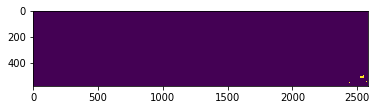

In [71]:

# TEST FONCTION DES NUAGES DE POINTS

traj_map = plot_loc(9999964,0.00005,0.00005,1)
plt.imshow(traj_map)


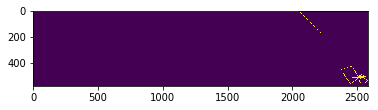

In [72]:

# TEST DE LA FONCTION POUR AFFICHER LES TRAJECTOIRES A PARTIR DES NUAGES DE POINTS

traj_map = plot_traj(9999964,0.00005,0.00005,1)
plt.imshow(traj_map)

